In [1]:
%reset -sf
import numpy as np
import psana as ps
import matplotlib.pyplot as plt
import sys
import time
import pickle
import os
from Functions import * 
from raw_data_class import RawData as RDC
from processed_data_class import processed_data_class as PDC
%matplotlib notebook
import warnings
warnings.filterwarnings('ignore')

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [8]:
save_dir = '/reg/d/psdm/cxi/cxilv2718/results/data/'
calib_dir = '/reg/d/psdm/cxi/cxilv2718/results/calibrations/'

# runs = (170, 172, 174, 176, 177, 178, 179, 180, 184, 186, 188, 190, 
#         192, 194, 196, 198, 200, 202, 204, 209, 210, 211, 216, 217,
#         219, 221, 223, 225, 227, 229, 231, 233, 236, 237, 238, 239, 
#         241, 242, 244, 246, 248, 250, 252, 254, 255, 256, 258, 260, 
#         262, 264, 266, 268, 269, 271, 273, 275, 277, 278, 280, 282,   # The first half  | 170 - 283 are in focus
#         283, 171, 173, 175, 181, 182, 183, 185, 187, 189, 191, 193,   # The second half | 171 - 281 are out of focus
#         195, 197, 199, 201, 203, 205, 206, 207, 208, 212, 213, 214,
#         215, 218, 220, 222, 224, 226, 228, 230, 232, 234, 243, 245,
#         247, 249, 251, 253, 257, 259, 261, 263, 265, 267, 270, 272,
#         274, 276, 279, 281)
        
runs = (285,286,287,288,289)

# runs 236, 237, 238, 239 are no probe: They have been processed with showing a large roi

# 48-59 FeII experiment runs full power, 3mm slit (also 63?)
# 67-70 H2O experiment runs full power, 3mm slit
# 44,71,88-90 are maps (no sample) - all the same, 3mm slit
# 72-74 different focus (-0.1, -0.2, -0.3)
# 78 new focus position: FeII 
# 79-80
# 81-87 different attenuation

# epix_roi= [90,140,190,300]   # up until run 97
# epix_roi= [90,150,195,290]   # up until run 159
epix_roi = [95,145,205,305] 
# epix_roi = [0,350,0,350]

xrt_roi = [300,1100]
# calibration_file = 'calibration_2' # up until run 97
# calibration_file = 'calibration_3'
calibration_file = 'calibration_4'
# Processing or Loading
process_raw = False
on_off = True # Do you want to plot the raw data?


x_axis = 'pixels' # 'pixels' or 'energy'
to_cal_file = [calib_dir, calibration_file]

In [9]:
# Energy Calibration, plot raw calibration runs with pixel axis and populate these arrays
save_cal = False
if save_cal is True:
    calib_runs = list(range(159,165))
    notch_energies = [7.05,7.055,7.06,7.065,7.07,7.075,7.08] # keV
    xrt_pixels =  [862,775,694,609,522,441,357] # enter 0 if you can't see the notch
    epix_pixels = [0,229,242,255,267,280,0] # enter 0 if you can't see the notch

    labels = ['notch_energies','xrt_pixels','epix_pixels','rois','to_cal_file','calib_runs']
    rois = [xrt_roi,epix_roi]
    calib_in = [labels, notch_energies,xrt_pixels,epix_pixels,rois,to_cal_file,calib_runs]
    calib_out = energy_calib.energy_calib(calib_in,save_cal)
    print('')
    print('The loaded calibration settings are: ')
    current_cal = [print(calib_out[0][i] +' : '+ str(calib_out[i+1])) for i in list(range(0,5))+list(range(8,10))]
if os.path.exists(to_cal_file[0]+to_cal_file[1]+'.pkl') and save_cal is False:
    with open(to_cal_file[0] + to_cal_file[1] +'.pkl', "rb") as f:
        calib_out = pickle.load(f)
    print('The loaded calibration settings are: ')
    current_cal = [print(calib_out[0][i] +' : '+ str(calib_out[i+1])) for i in list(range(0,5))+list(range(8,10))]   
    
if not os.path.exists(to_cal_file[0]+to_cal_file[1]+'.pkl'):
    print(to_cal_file[1] + ' does not exist.')
    print('No calibration file loaded.')

The loaded calibration settings are: 
notch_energies : [7.05, 7.055, 7.06, 7.065, 7.07, 7.075, 7.08]
xrt_pixels : [862, 775, 694, 609, 522, 441, 357]
epix_pixels : [0, 229, 242, 255, 267, 280, 0]
rois : [[300, 1100], [95, 145, 205, 305]]
to_cal_file : ['/reg/d/psdm/cxi/cxilv2718/results/calibrations/', 'calibration_4']
epix_motor : 23.237
time_calibrated : 2021-05-31 04:51:01.066290


exp=cxilv2718:run=285:smd
exp=cxilv2718:run=286:smd
exp=cxilv2718:run=287:smd
exp=cxilv2718:run=288:smd
exp=cxilv2718:run=289:smd


<IPython.core.display.Javascript object>


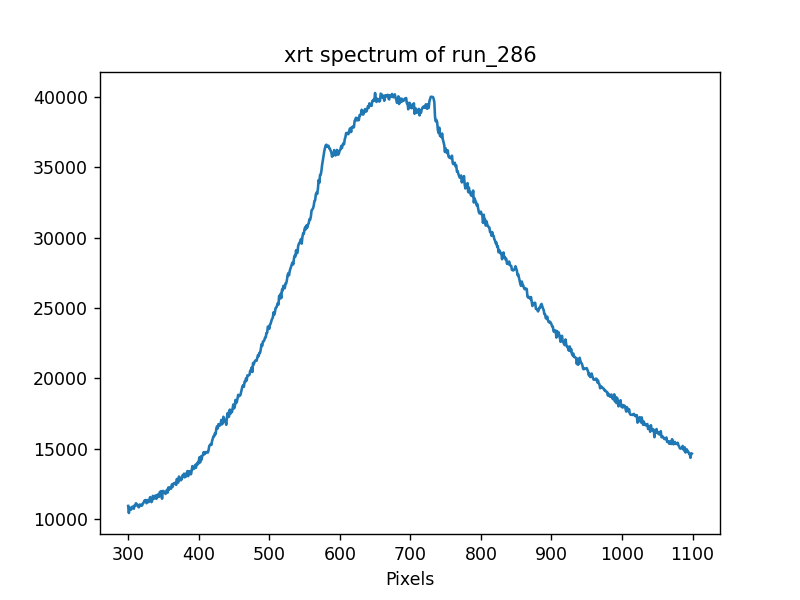

<IPython.core.display.Javascript object>


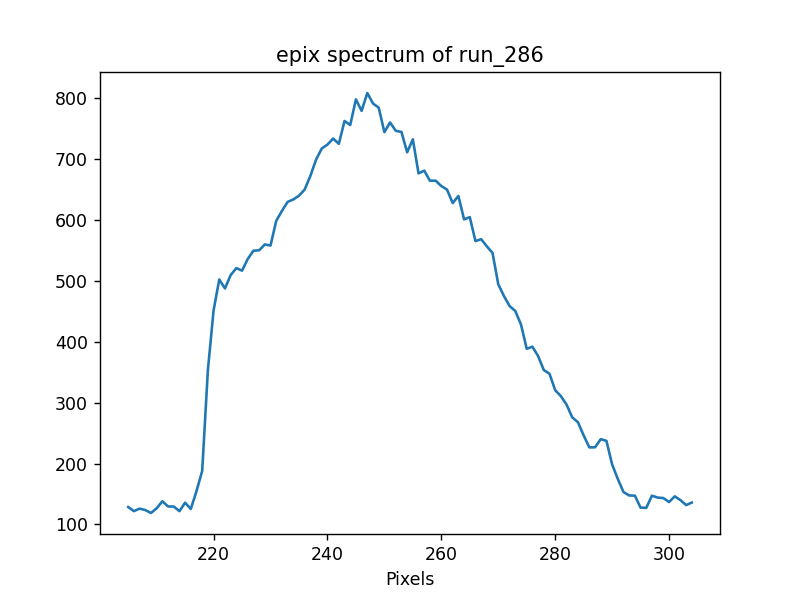

<IPython.core.display.Javascript object>


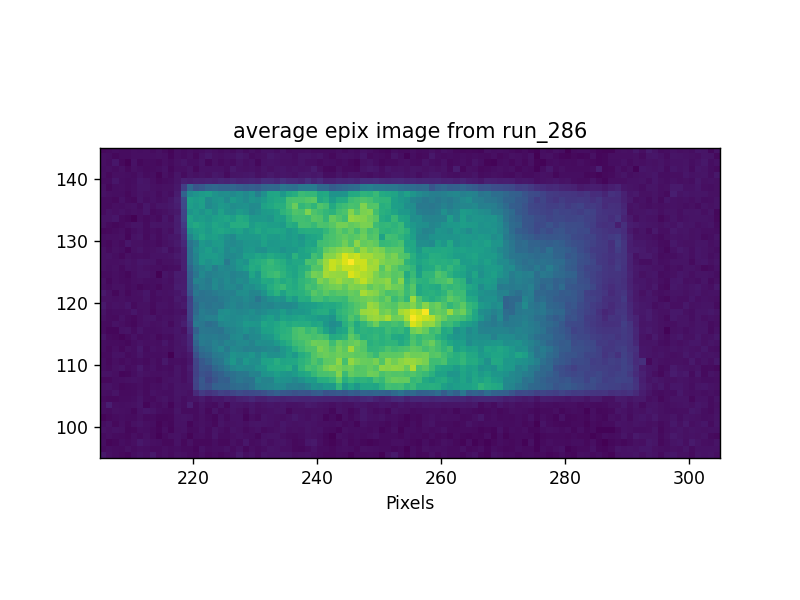

<IPython.core.display.Javascript object>


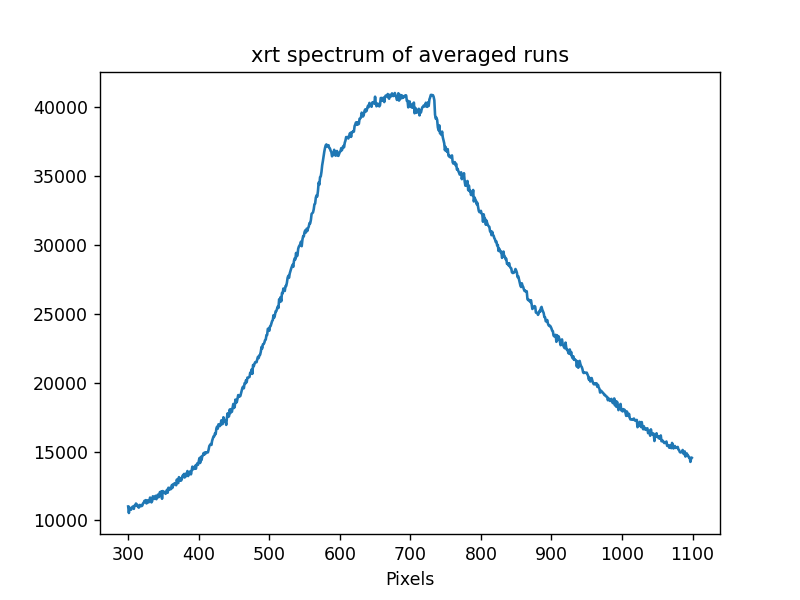

<IPython.core.display.Javascript object>


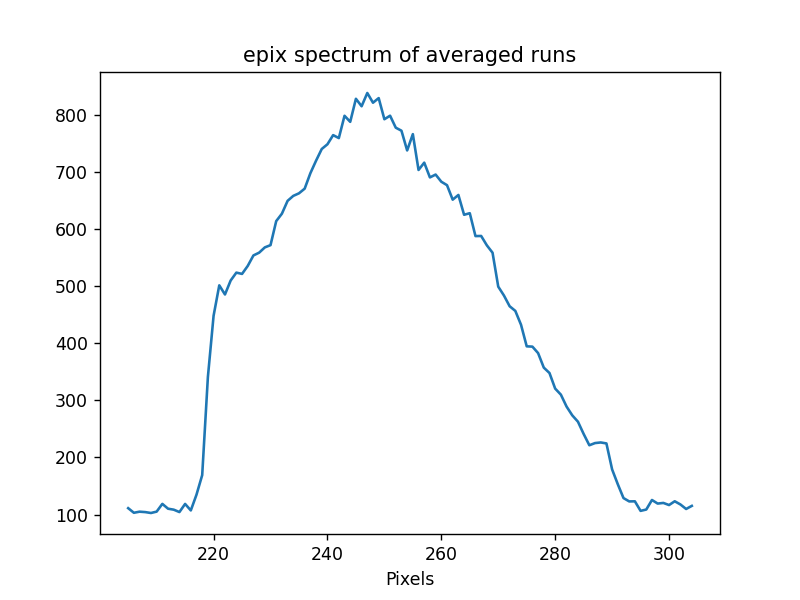

In [10]:
# Raw Data
plot_one = 286
plot_one_idx = np.searchsorted(runs,plot_one)
raw_datas = []
for run in runs:
    scan_name = 'run_' + str(run)
    ds_string = 'exp=cxilv2718:run='+str(run)+':smd'
    print(ds_string)
    if process_raw:
        raw_data = load_data.load_data(save_dir,scan_name,ds_string,epix_roi,xrt_roi)
    else:
        if os.path.exists(save_dir + scan_name + "/" + "rawdata.pkl"):
            with open(save_dir + scan_name + "/" + "rawdata.pkl", "rb") as f:
                raw_data = pickle.load(f)
        else:
            print('You are trying to load a file that does not exist.')
    if os.path.exists(save_dir + scan_name + "/" + "rawdata.pkl"):
        raw_datas = raw_datas + [raw_data]

[load_data.add_cal_info(raw_datas[i],to_cal_file) for i in range(0,len(raw_datas))]
plot_raw.plot_raw(raw_datas, plot_one, x_axis, on_off,to_cal_file)

# plot_raw.plot_raw(raw_datas, plot_one, x_axis, on_off,to_cal_file)
# plt.figure()
# [plt.plot(raw_datas[i].epix_energy_windowed,np.mean(raw_datas[i].epix_windowed,0),label=raw_datas[i].scan_name) for i in range(0,len(runs))]
# # [plt.plot(raw_datas[i].xrt_energy_windowed,np.mean(raw_datas[i].xrt_windowed,0),label=raw_datas[i].scan_name) for i in range(0,len(runs))]

# plt.legend()
# plt.xlabel('energy,keV')
# # plt.title('XRT Spectra Stacked')
# plt.title('Epix Spectra Stacked')
# plt.show()

In [ ]:
# Applies an energy window to both spectra. Decide on window based on epix spectrum above.
# Also, reduces the resolution of the xrt spectrometer to match that of the epix.
energy_window = [7.051,7.07785]
for i in range(0,len(raw_datas)):
    if hasattr(raw_datas[i],'xrt_red_res'): #this if statement must be commented out for the windowing to happen
        continue
    print(raw_datas[i].scan_name, end="\r", flush=True)
    reduce_xrt_res.apply_window(raw_datas[i],energy_window)
    reduce_xrt_res.reduce_res(raw_datas[i])


# plt.figure()
# plt.plot(raw_data.epix_energy_windowed,np.sum(raw_data.xrt_red_res,0))
# plt.plot(raw_data.xrt_energy_windowed,np.sum(raw_data.xrt_windowed,0),alpha=0.5)
# plt.show()

In [ ]:
# Inputs for filters
# filters = [filter0,filter1, ...,filterN]

            # filterX[0] = On/Off # True or False
            # filterX[1] = Type # 'bounds','linearity','rms'
            # filterX[2] = [par0,par1,...,parN]
            
                # If Type = 'bounds'    # par0 = 'key_0' # key_X is string from raw_data.getKeys()
                                        # par1 = lower bound # check raw_data.keyX for starting point 
                                        # par2 = upper bound # 'None' if no upper bound
                                        # par3 = number of stds from median allowed
            
                # If Type = 'linearity' # par0 = 'key_0','key_1' # key_0 and key_1 and x and y values, respectively
                                        # par1 = width of filter
                                        # par2 = force fit through origin? # True or False
                    
# filterX[3] = [in_1, in_2]
                # in_1 = On/Off # True or false
                # in_2 = plot_one # The run you want to see plots for. Declared above in the 2nd block.

# print(raw_data.getKeys()) 
plot_one = 277
# plot_one = 68
# plot_one = 76



suspress_output = True
filt0 = [True,'bounds',['low_diode_us',0.055,'None',2.3],[True,plot_one]]
filt1 = [True,'bounds',['high_diode_us',0.02,'None',2.2],[True,plot_one]]
filt2 = [True,'bounds',['photon_energies',0.945,'None',2.2],[True,plot_one]]
filt3 = [True,'bounds',['pulse_energies_fee',0.2,'None',2.2],[True,plot_one]]

# The linearity filters create their fit based on data points that make it through
# the bounds filters.

# filt4 = [True,'linearity',['xrt_intensity','epix_intensity',0.08,True],[True,plot_one]]
filt5 = [True,'linearity',['high_diode_us','fluo_diode_ds',0.5,True],[True,plot_one]]
filt6 = [True,'linearity',['low_diode_us','xrt_intensity',0.09,True],[True,plot_one]]
# filt7 = [True,'linearity',['low_diode_us','epix_intensity',0.1,True],[True,plot_one]]


filters = [filt0,filt1,filt2,filt3,filt5,filt6]
# filters = [filt0,filt1,filt2,filt3,filt4,filt5,filt6]
# filters = [filt0,filt1,filt2,filt3,filt4,filt6,filt7]


conditions = [Filters.filtering(raw_datas[i],filters,suspress_output) for i in range(0,len(raw_datas))]

In [ ]:
# Make or load processed data
make_pro = False
pro_datas = []
probe_run = [166,make_pro]
scaling = True # True = 'avg(x)/avg(y)'| False =  'avg(x/y)' 
                        ## THIS ONE ###

for i in range(0,len(raw_datas)):
    if make_pro:
#         if probe_run[1]:
#             new_scale = raw_datas[runs.index(probe_run[0])].make_pro_data(conditions[runs.index(probe_run[0])],filters)
#             probe_run,spec_scale = new_scale.scale_spectrometers(probe_run,scaling)
        processed_data = raw_datas[i].make_pro_data(conditions[i],filters)
        print('Appling Filters to ' +raw_datas[i].scan_name, end="\r", flush=True)
        pro_datas = pro_datas + [processed_data]
    else:
        if os.path.exists(raw_datas[i].save_dir + raw_datas[i].scan_name + "/" + "pro_data.pkl"):
            with open(raw_datas[i].save_dir + raw_datas[i].scan_name + "/" + "pro_data.pkl", "rb") as f:
                processed_data = pickle.load(f)
                pro_datas = pro_datas + [processed_data]
                print('Loaded processed_data for run ' + processed_data.scan_name)
        else:
            print('You are trying to load a file that does not exist.')
        
#     pro_datas[i].scale_spectrometers(probe_run,scaling)

len(pro_datas)

# probe_run = [26,True]
# probe_run = pro_datas[-1].scale_spectrometers(probe_run)

In [ ]:
# Enter runs to plot averages
all_shots = True
check_dim = True #print length of all epix and xrt shots and shot id. should be =

plot_stacked = True #plots average of Epix and average of XRT
plot_residual = True
plot_deltaT_T = True
plot_bootstrap = False
shot_by_shot = True
boot = 50 
fraction = 1/4
plot_type = 'DeltaT/T' #enter type of plot for bootlegging: 'stacked','residual', or'DeltaT/T'

scans_to_average = [115,117,120]
input_vars = [scans_to_average,all_shots,runs,boot,fraction,plot_type,plot_stacked,plot_residual,plot_deltaT_T, plot_bootstrap,check_dim,shot_by_shot]
plot_average.plot_average(pro_datas,input_vars)

In [ ]:
#Plot comparison of residuals and deltaT/T for multiple runs

energy = pro_datas[0].epix_energy_windowed
scans_to_plot = [170,172,174]
idx = np.searchsorted(runs,scans_to_plot)

compare_resid = True
compare_deltaT_T = True

plot_average.plot_comparison(pro_datas,scans_to_plot,runs,energy,compare_resid,compare_deltaT_T)
    


In [ ]:
test = [[150],[154],[155]]
idx = [np.searchsorted(runs,test[i]) for i in range(0,len(test))] # runs
labels = '0fs','5fs','10fs','15fs'
for j in range(0,len(idx)):
    plt.figure()
    for i in idx[j]:
        _, bins, _ = plt.hist(pro_datas[i]., 100,rwidth=.75,alpha = 0.7)
        plt.legend()
    plt.xlabel('Intensity of Fluoresence Diode')
    plt.ylabel('# shots')
    plt.show()

In [ ]:
test = [[171],[173],[175]]
idx = [np.searchsorted(runs,test[i]) for i in range(0,len(test))] # runs
labels = '0fs','5fs','10fs','15fs'

fig,ax = plt.subplots()
for i in idx:
    ax.scatter(raw_datas[i].fluo_diode_ds,raw_datas[i].high_diode_us,label='unfiltered')
#         plt.scatter(pro_datas[i].fluo_diode_ds,pro_datas[i].high_diode_us,alpha=0.5,label='filtered')
    plt.legend()
    plt.title(test[j])
    plt.xlabel('Downstream Fluoresence Diode')
    plt.ylabel('Upstream Pump Diode')
    plt.show()

In [ ]:
set_0 = [170]
set_1 = [171]
scans_to_plot = set_0,set_1

scale_runs = [[166,167]]
# if type(scans_to_plot) is list:
#     scans_to_plot = np.asarray(scans_to_plot)[np.newaxis,:]
# runs = np.append(np.concatenate(scale_runs),np.concatenate(scans_to_plot))
# runs = runs.tolist()

energy = pro_datas[0].epix_energy_windowed

shots_in_scale = plot_average.gather_shots(pro_datas,[scale_runs,1,runs])
scale = np.mean(np.mean(shots_in_scale[1],0),0)/np.mean(np.mean(shots_in_scale[0],0),0)

compare = np.asarray(plot_average.gather_shots(pro_datas,[scans_to_plot,1,runs]))
epix_means = [np.mean(compare[1][i],0) for i in range(0,compare[0].shape[0])]
xrt_means = [np.mean(scale*compare[0][i],0) for i in range(0,compare[0].shape[0])]

resid_means =[epix_means[i]-xrt_means[i] for i in range(0,compare[0].shape[0])]
deltaT_T_means =[(resid_means[i]/xrt_means[i]) for i in range(0,compare[0].shape[0])]

resid_sbs = [compare[1][i]-(scale*compare[0][i]) for i in range(0,compare[0].shape[0])]
deltaT_T_sbs = [(resid_sbs[i])/(scale*compare[0][i]) for i in range(0,compare[0].shape[0])]


plt.figure()
plt.plot(energy[0:60],deltaT_T_means[0][0:60])
plt.plot(energy[0:60],deltaT_T_means[1][0:60])

plt.legend
plt.title('DeltaT/T avg(170,172,174)-avg(171,173) ')
plt.xlabel('energy, keV')
# plt.show()


In [ ]:
print(runs)

In [ ]:
energy = pro_datas[0].epix_energy_windowed
# set_1 = [170,172,174,184,186,188]           
# set_2 = [171,173,175,185,187,189]
# set_0 = [218,220,222,224,226,228]
# set_3 = [217,219,221,223,225,227,229,231]# set_0 = [[236,237,238]]
# set_5 = [123,125,127]
# set_6 = [129,131,133]
# set_7 = [130,132,135]
# sets = [set_0,set_1,set_2,set_3,set_4,set_5,set_6,set_7]
set_0 = [269, 271, 273, 275, 277, 278, 280, 282, 283]
set_1 = [270, 272, 274, 276, 279, 281]
sets = set_0,set_1
scale_runs = [[268]]
scale_shots = plot_average.gather_shots(pro_datas,[scale_runs,1,runs])
scale = np.mean(np.mean(scale_shots[1],0),0)/np.mean(np.mean(scale_shots[0],0),0)
# input_vars = [scans_to_average,all_shots,runs]
# all_xrt_shots,all_epix_shots,all_xrt_shots_based,shot_id

compare = np.asarray(plot_average.gather_shots(pro_datas,[sets,1,runs]))
# compare = [water,runs1,runs2,...,runsN]
print(compare.shape)
epix_means = [np.mean(compare[1][i],0) for i in range(0,compare[0].shape[0])]
xrt_means = [np.mean(scale*compare[0][i],0) for i in range(0,compare[0].shape[0])]

# resid_means_epix =[epix_means[i]-epix_means[0] for i in range(0,compare[0].shape[0])]
# deltaT_T_means_epix= [(resid_means_epix[i]/epix_means[0]) for i in range(compare[0].shape[0])]

# resid_means_xrt =[xrt_means[i]-xrt_means[0] for i in range(0,compare[0].shape[0])]
# deltaT_T_means_xrt =[(resid_means_xrt[i]/xrt_means[0]) for i in range(0,compare[0].shape[0])]

resid_means_both =[epix_means[i]-xrt_means[i] for i in range(0,compare[0].shape[0])]
deltaT_T_means_both =[(resid_means_both[i]/xrt_means[i]) for i in range(0,compare[0].shape[0])]


    
set_2 = [190,192,194,196,198,200,202,204]
set_3 = [191,193,195,197,199,201,203,205]


sets = set_2,set_3
scale_runs = [[206,207,208]]
scale_shots = plot_average.gather_shots(pro_datas,[scale_runs,1,runs])
scale = np.mean(np.mean(scale_shots[1],0),0)/np.mean(np.mean(scale_shots[0],0),0)
compare = np.asarray(plot_average.gather_shots(pro_datas,[sets,1,runs]))
print(compare.shape)
epix_means = [np.mean(compare[1][i],0) for i in range(0,compare[0].shape[0])]
xrt_means = [scale*np.mean(compare[0][i],0) for i in range(0,compare[0].shape[0])]
resid_means_both =[epix_means[i]-xrt_means[i] for i in range(0,compare[0].shape[0])]
deltaT_T_means_both_2 =[(resid_means_both[i]/xrt_means[i]) for i in range(0,compare[0].shape[0])]

set_4 = [256,258,260,262,264,266]
set_5 = [257,259,261,263,265,267]
# set_1 = [209,210,211]
# set_2 = [212,213,214]


sets = set_4,set_5
scale_runs = [[254,255]]
scale_shots = plot_average.gather_shots(pro_datas,[scale_runs,1,runs])
scale = np.mean(np.mean(scale_shots[1],0),0)/np.mean(np.mean(scale_shots[0],0),0)
compare = np.asarray(plot_average.gather_shots(pro_datas,[sets,1,runs]))
print(compare.shape)
epix_means = [np.mean(compare[1][i],0) for i in range(0,compare[0].shape[0])]
xrt_means = [scale*np.mean(compare[0][i],0) for i in range(0,compare[0].shape[0])]
resid_means_both =[epix_means[i]-xrt_means[i] for i in range(0,compare[0].shape[0])]
deltaT_T_means_both_3 =[(resid_means_both[i]/xrt_means[i]) for i in range(0,compare[0].shape[0])]





plt.figure()
# plt.plot(energy,deltaT_T_means_both[0],label = '0fs 242,244,246,248,250,252| in focus')
# plt.plot(energy,deltaT_T_means_both[1],label = '0fs 243,245,247,249,251,253 | out of focus')


plt.plot(energy,deltaT_T_means_both_3[0],label = '5fs 256+ | low fluence | in focus',linestyle=(0, (5, 1)))
plt.plot(energy,deltaT_T_means_both_3[1],label = '5fs 257+ | low fluence | out of focus',linestyle=(0, (5, 1)),color='k')

plt.plot(energy,deltaT_T_means_both_2[0],label = '5fs 190+ | higher fluence | in focus')#,linestyle='dotted')
plt.plot(energy,deltaT_T_means_both_2[1],label = '5fs 191+ | higher fluence | out of focus')#,linestyle='dotted')

plt.legend()
plt.xlabel('energy, keV')
plt.title('(epix-xrt)/xrt')


# txt = ('solid: 217,219,221,223,225,227,229,231, dashed')
# plt.figtext(0.5, 0.01, txt, wrap=False, horizontalalignment='center', fontsize=8)
# plt.tight_layout()


# runs = (166,167,170,171,172,173,174,175,
#         184,185,186,187,188,189,190,191,
#         192,193,194,195,196,197,198,199,
#         200,201,202,203,204,205,206,207,
#         208,209,210,211,212,213,214,215,
#         216,217,218,219,220,221,222,223)





# plt.figure()
# [plt.plot(energy,deltaT_T_means_epix[i]) for i in range(0,len(deltaT_T_means_epix))]
# plt.legend((sets[1:]))
# plt.title('(Epix_sample-Epix_water)/Epix_water')
# plt.xlabel('energy, keV')

# plt.figure()
# [plt.plot(energy,deltaT_T_means_xrt[i]) for i in range(0,len(deltaT_T_means_xrt))]
# plt.legend((sets[1:]))
# plt.title('(xrt_sample-xrt_water)/xrt_water')
# plt.xlabel('energy, keV')
# plt.show()
# [print(compare[2][i][:]) for i in range(0,compare[0].shape[0])]

x=[7055.0,7065.0,7075.0]
y=[1/0.662740,1/0.66380,1/0.66485]

m,b = np.polyfit(x,y,1)
print(m,b)



# plt.legend(('0 fs','10 fs'))
# plt.title('(epix-xrt)/xrt | out of focus')

# plt.xlabel('energy, keV')
# plt.show()

# plt.figure()
# [plt.plot(energy,epix_means[i]) for i in range(0,len(epix_means))]
# plt.legend((sets))
# plt.title('epix')
# plt.xlabel('energy, keV')
# plt.show()

# plt.figure()
# plt.legend((sets))
# [plt.plot(energy,xrt_means[i]) for i in range(0,len(xrt_means))]
# plt.title('xrt')
# plt.xlabel('energy, keV')
# plt.show()

# plt.figure()
# idx = np.searchsorted(runs,[68,50,75]) # runs

# [plt.scatter(pro_datas[i].fluo_diode_ds,pro_datas[i].high_diode_us) for i in idx]
# plt.xlabel('fluo_diode')
# plt.ylabel('pump_diode')
# plt.legend(('water','sample, normal','sample, foil'))
# print(compare[2][:])


In [ ]:
print(runs)

In [ ]:
energy = pro_datas[0].epix_energy_windowed
sets = [[110,111,112],[115,117,120],[116,119,121]]
# input_vars = [scans_to_average,all_shots,runs]
# all_xrt_shots,all_epix_shots,all_xrt_shots_based,shot_id
compare = [plot_average.gather_shots(pro_datas,[sets[i],0,runs]) for i in range(0,len(sets))]
# compare = [water,r72,r73,r74,sample]

epix_means = [np.mean(compare[i][1],0) for i in range(0,len(compare))]
xrt_means = [np.mean(compare[i][2],0) for i in range(0,len(compare))]
# epix_means = [epix_means[0],epix_means[1],epix_means[2]]
resid_means_epix =[epix_means[i]-epix_means[0] for i in range(0,len(compare))]
deltaT_T_means_epix= [(resid_means_epix[i]/epix_means[0]) for i in range(0,len(compare))]

resid_means_xrt =[xrt_means[i]-xrt_means[0] for i in range(0,len(compare))]
deltaT_T_means_xrt =[(resid_means_xrt[i]/xrt_means[0]) for i in range(0,len(compare))]

resid_means_both =[epix_means[i]-xrt_means[i] for i in range(0,len(compare))]
deltaT_T_means_both =[(resid_means_both[i]/xrt_means[i]) for i in range(0,len(compare))]


In [ ]:
energy = pro_datas[0].epix_energy_windowed

epix_water_mean = np.mean(water[1],0)
epix_sample_mean = np.mean(sample[1],0)

xrt_water_mean = np.mean(water[0],0)
xrt_sample_mean = np.mean(sample[0],0)
scale = np.max(epix_water_mean)/np.max(xrt_water_mean)
#################

epix_resid_means = epix_sample_mean-epix_water_mean
epix_DeltaT_T_means = epix_resid_means/epix_water_mean

xrt_resid_means = xrt_sample_mean-xrt_water_mean
xrt_DeltaT_T_means = xrt_resid_means/xrt_water_mean

#################

both_resid_sample_sbs = sample[1]-sample[0]*scale
both_DeltaT_T_sample_sbs = both_resid_sample/sample[0]*scale

both_resid_water_sbs = water[1]-water[0]*scale
both_DeltaT_T_water_sbs = both_resid_water/water[0]*scale
both_DeltaT_T_sample = np.mean(both_DeltaT_T_sample_sbs,0)
both_DeltaT_T_water = np.mean(both_DeltaT_T_water_sbs,0)
#################

plt.figure()
plt.plot(energy[0:70],epix_DeltaT_T_means)
plt.title('DeltaT_T : (Epix_sample-Epix_water)/Epix_water')
plt.xlabel('energy, keV')
print(water[1].shape)
print(sample[1].shape)

plt.figure()
plt.plot(energy[0:70],xrt_DeltaT_T_means)
plt.title('DeltaT_T : (XRT_sample-XRT_water)/xrt_water')
plt.xlabel('energy, keV')
print(water[1].shape)
print(sample[1].shape)

plt.figure()
plt.plot(energy[0:70],both_DeltaT_T_sample,label='sample')
plt.plot(energy[0:70],both_DeltaT_T_water,label='water',alpha=0.6,linestyle='dashed')

plt.title('DeltaT_T : (XRT_sample-XRT_water)/xrt_water')
plt.xlabel('energy, keV')
print(water[1].shape)
print(sample[1].shape)

In [ ]:
compare[1][4]

In [ ]:
plt.figure()
plt.

In [ ]:
plot_type = 'DeltaT/T'
boot = 100
fraction = 1/5
if type(boot)==int:
    plt.figure()
    for j in range(1,len(compare)):
        for i in range(0,boot):
            if j is 1:
                color = 'k'
            if j is 2:
                color = 'b'
            if j is 3:
                color = 'g'
            if j is 4:
                color = 'c'
            rand_=np.random.choice(len(compare[j][1]), np.int64(len(compare[2][1])*fraction), replace=False)
            rand_shots_epix = np.mean(compare[j][1][rand_],0)
            rand_shots_xrt = np.mean(scale*compare[j][0][rand_],0)
            rand_shots_residual = rand_shots_epix-rand_shots_xrt
            rand_shots_DeltaT_T = rand_shots_residual/rand_shots_xrt
            if plot_type == 'stacked':
                plt.plot(energy,rand_shots_epix)
                plt.plot(energy,rand_shots_xrt,linestyle='dashed',alpha=0.6)
            if plot_type == 'residual':
                plt.plot(energy,rand_shots_residual)
            if plot_type == 'DeltaT/T':
                plt.plot(energy,rand_shots_DeltaT_T,color)
plt.legend((sets[1:]))
plt.title('(epix-xrt)/xrt| 100 loop bootstrap')
plt.xlabel('energy, keV')

In [ ]:
plt.figure()
plt.plot(energy,(0.66*epix_means[1]-xrt_means[1])/xrt_means[1])
plt.plot(energy,0.1375+(epix_means[2]-xrt_means[2])/xrt_means[2])
plt.title('(epix-xrt)/xrt')
plt.legend('[154,155]','156')
plt.xlabel('energy, keV')
plt.ylabel('Delta T / T')


var1=epix_means[1]
var2=epix_means[2]/0.66

plt.figure()
plt.plot(energy,var1)
plt.plot(energy,var2)

In [ ]:
numerator = np.mean(pro_datas[0].xrt_norm,0)*(np.mean(pro_datas[0].epix_windowed,0)-np.mean(pro_datas[0].xrt_based_norm,0))
denomenator = (np.mean(pro_datas[0].epix_windowed,0)-np.mean(pro_datas[0].xrt_norm,0))*np.mean(pro_datas[0].xrt_based_norm,0)
alpha = numerator/denomenator
plt.figure()
plt.plot(energy,alpha*(np.mean(pro_datas[0].epix_windowed,0)-np.mean(pro_datas[0].xrt_norm,0))/np.mean(pro_datas[0].xrt_norm,0))
plt.plot(energy,(np.mean(pro_datas[0].epix_windowed,0)-np.mean(pro_datas[0].xrt_based_norm,0))/np.mean(pro_datas[0].xrt_based_norm,0))

In [ ]:
r1 = (np.mean(pro_datas[1].epix_norm,0)-np.mean(pro_datas[1].xrt_norm,0))/np.mean(pro_datas[1].xrt_norm,0)
r2 = (0.66*np.mean(pro_datas[5].epix_norm,0)-np.mean(pro_datas[5].xrt_norm,0))/np.mean(pro_datas[5].xrt_norm,0)
r3 = (np.mean(pro_datas[6].epix_norm,0)-np.mean(pro_datas[6].xrt_norm,0))/np.mean(pro_datas[6].xrt_norm,0)
rn = (np.mean(pro_datas[0].epix_windowed,0)-np.mean(pro_datas[0].xrt_norm,0))/np.mean(pro_datas[0].xrt_norm,0)
num1 = (np.mean(pro_datas[1].epix_norm,0)-np.mean(pro_datas[1].xrt_based_norm,0))/np.mean(pro_datas[1].xrt_based_norm,0)
num2 = (0.66*np.mean(pro_datas[5].epix_norm,0)-np.mean(pro_datas[5].xrt_based_norm,0))/np.mean(pro_datas[5].xrt_based_norm,0)
num3 = (np.mean(pro_datas[6].epix_norm,0)-np.mean(pro_datas[6].xrt_based_norm,0))/np.mean(pro_datas[6].xrt_based_norm,0)
den = (np.mean(pro_datas[0].epix_norm,0)-np.mean(pro_datas[0].xrt_based_norm,0))/np.mean(pro_datas[0].xrt_based_norm,0)
plt.figure()
plt.plot(energy,0.117+num3)
plt.plot(energy,num2)

plt.figure()
plt.plot(energy,0.00375+r3)
plt.plot(energy,r2)

In [ ]:
high_diode_good = []
low_diode_good = []
high_diode_meh = []
low_diode_meh = []
for i in range(0,len(pro_datas)):
    high_diode_good.append(pro_datas[i].high_diode_us)
    low_diode_good.append(pro_datas[i].low_diode_us)
    high_diode_meh.append(raw_datas[i].high_diode_us)
    low_diode_meh.append(raw_datas[i].low_diode_us)
    
all_pump_good = np.concatenate(high_diode_good)
all_probe_good = np.concatenate(low_diode_good)
all_pump_meh = np.concatenate(high_diode_meh)
all_probe_meh = np.concatenate(low_diode_meh)


fig,ax = plt.subplots(1,2)
ax[1].hist(all_pump_good, 50,rwidth=.75,alpha = 0.7,label='Probe Diode: Meh',color='b')
ax[1].hist(all_probe_good, 50,rwidth=.75,alpha = 0.5,label='Probe Diode: Good',color='y')

ax[0].hist(all_pump_meh, 50,rwidth=.75,alpha = 0.5,label='Pump Diode: Meh',color='g')
ax[0].hist(all_pump_good, 50,rwidth=.75,alpha = 0.5,label='Pump Diode: Good',color='k')

ax[0].legend()
ax[1].legend()
plt.ylabel('# of Shots')
plt.suptitle(str(len(all_probe_meh)) + ' Meh Shots | ' +str(len(all_probe_good)) + ' Good Shots')
plt.tight_layout()

In [ ]:
fig,ax = plt.subplots(2,1,sharey=True,sharex=True)
ax[1].hist(raw_datas[0].low_diode_us, 100,rwidth=.75,alpha = 0.9,label='Probe Diode: Run 283')
ax[1].hist(raw_datas[0].high_diode_us, 100,rwidth=.75,alpha = 0.6,label='Pump Diode: Run 283')
ax[0].hist(raw_datas[1].low_diode_us, 100,rwidth=.75,alpha = 0.9,label='Probe Diode: Run 284')
ax[0].hist(raw_datas[1].high_diode_us, 100,rwidth=.75,alpha = 0.6,label='Pump Diode: Run 284')
ax[1].legend()
ax[0].legend()
plt.xlabel('Reading from Diode')
# plt.title('Shot by Shot Distribution of Pump and Probe Intensities | run 213')
plt.ylabel('# shots')
